In [1]:
! pip install rasterio
! pip install earthpy
! pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.4 MB/s eta 0:00:00


In [59]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Parameters
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
N_CLASSES = 9
CLASSES = list(range(N_CLASSES))
PALETTE = ['#E00E42', '#393608', '#4c5ff9', '#77EEFC', '#6DFF86', '#E48C0A', '#BD10DD', '#11A21F', '#F9ED00']
SAMPLE_PATH = '/content/drive/MyDrive/DL/Samples_LC_2024.csv'
IMAGE_PATH = '/content/drive/MyDrive/DL/Landsat_2024.tif'

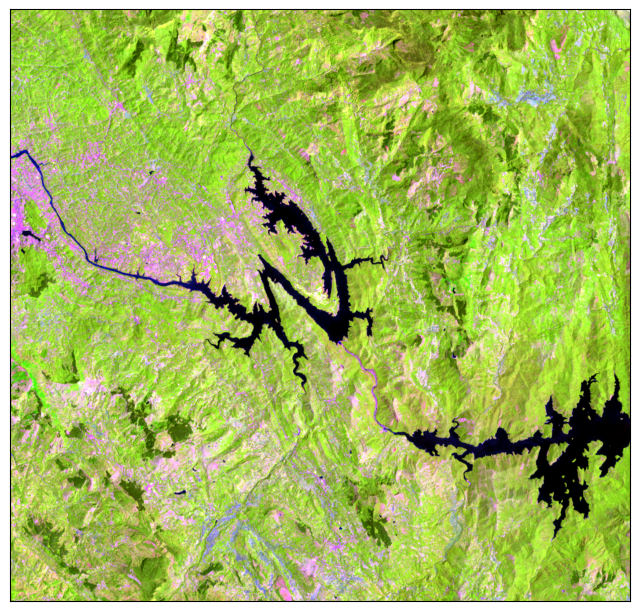

<Axes: >

In [119]:
# Load image
import rasterio
import numpy as np
import earthpy.plot as ep
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [120]:
# Load samples data
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)  # shuffle
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
120,0.006525,0.014747,0.037105,0.017745,0.078025,0.025417,0.012932,0.140331,0.715636,0.508568,-0.355424,-0.508568,0.325554,1128,3,train
353,0.021732,0.024922,0.051845,0.039607,0.287850,0.157995,0.076677,0.463632,0.579305,0.291256,-0.694756,-0.291256,0.346515,482,9,train
287,0.020522,0.030175,0.069390,0.047225,0.345765,0.195615,0.091445,0.532042,0.581688,0.277347,-0.665715,-0.277347,0.362886,973,7,train
42,0.194185,0.240481,0.274334,0.302645,0.402016,0.596208,0.593609,0.175657,-0.192434,-0.194537,-0.188782,0.194537,0.002184,724,1,test
162,0.023492,0.029144,0.056960,0.039305,0.154131,0.060562,0.031591,0.245066,0.659802,0.435824,-0.460328,-0.435824,0.314380,445,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.028415,0.036720,0.061195,0.051102,0.058032,0.031220,0.024757,0.015905,0.401921,0.300412,0.026525,-0.300412,0.115448,445,3,train
19,0.021719,0.028594,0.053564,0.042096,0.318568,0.164733,0.087554,0.509458,0.568830,0.318301,-0.712124,-0.318301,0.305917,773,1,train
180,0.019821,0.027177,0.056919,0.044764,0.274430,0.157266,0.074862,0.428744,0.571348,0.271403,-0.656442,-0.271403,0.354992,683,5,train
378,0.034272,0.038329,0.056726,0.048119,0.263375,0.168033,0.105085,0.425535,0.429599,0.221003,-0.645573,-0.221003,0.230478,507,9,train


In [121]:
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

train_features = train[FEATURES].to_numpy()
train_label = train[LABEL].to_numpy() - 1  # shift labels 1->0
test_features = test[FEATURES].to_numpy()
test_label = test[LABEL].to_numpy() - 1

In [122]:

# Standardize features

scaler = StandardScaler()
train_input = scaler.fit_transform(train_features).reshape(train_features.shape[0], train_features.shape[1], 1)
test_input = scaler.transform(test_features).reshape(test_features.shape[0], test_features.shape[1], 1)

train_output = to_categorical(train_label, N_CLASSES)
test_output = to_categorical(test_label, N_CLASSES)

In [123]:
import pandas as pd
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler #Scales features to zero mean and unit variance
from keras.utils import to_categorical #Converts integer labels to one-hot encoded vectors.
from keras import Sequential #build Conv1D deep learning model
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input
from keras.callbacks import EarlyStopping #training optimization
import earthpy.plot as ep
from matplotlib.colors import from_levels_and_colors
import matplotlib.pyplot as plt


# Build a smaller Conv1D model
# ----------------------------
input_shape = (train_input.shape[1], train_input.shape[2])
model = Sequential([
    Input((14,1)),
    Conv1D(16, 2, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Train
# ----------------------------
stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
result = model.fit(train_input, train_output, validation_data=(test_input, test_output),
                   epochs=450, batch_size=32, callbacks=[stop])



Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_65 (Conv1D)              │ (None, 13, 16)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_35         │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0955 - loss: 2.2099 - val_accuracy: 0.0678 - val_loss: 2.1495
Epoch 2/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1377 - loss: 2.1654 - val_accuracy: 0.1186 - val_loss: 2.1440
Epoch 3/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1880 - loss: 2.1559 - val_accuracy: 0.1017 - val_loss: 2.1432
Epoch 4/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1873 - loss: 2.1223 - val_accuracy: 0.1017 - val_loss: 2.1457
Epoch 5/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1556 - loss: 2.1204 - val_accuracy: 0.1017 - val_loss: 2.1279
Epoch 6/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1987 - loss: 2.0741 - val_accuracy: 0.1017 - val_loss: 2.1393
Epoch 7/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1852 - loss: 2.0681 - val_accuracy: 0.1017 - val_loss: 2.1186
Epoch 8/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1555 - loss: 2.0703 - val_accuracy: 0.1017 -

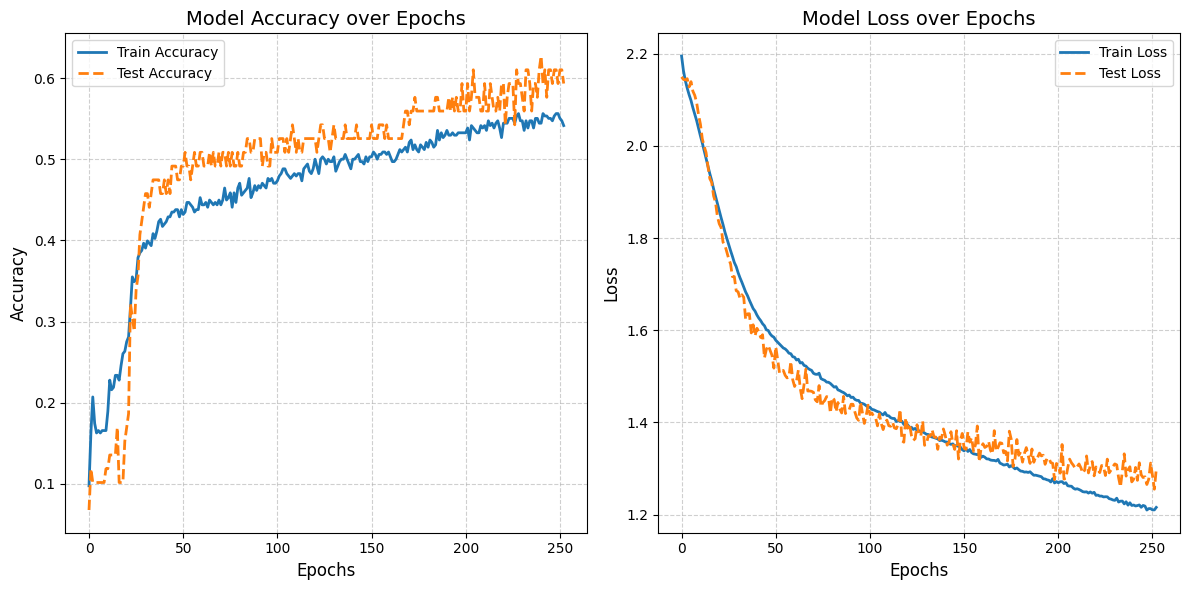

In [124]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert training history to DataFrame
history = pd.DataFrame(result.history)

# Create figure
plt.figure(figsize=(12, 6))

# -------------------------------
# Accuracy Plot
# -------------------------------
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Test Accuracy', linewidth=2, linestyle='--')
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# -------------------------------
# Loss Plot
# -------------------------------
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Test Loss', linewidth=2, linestyle='--')
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


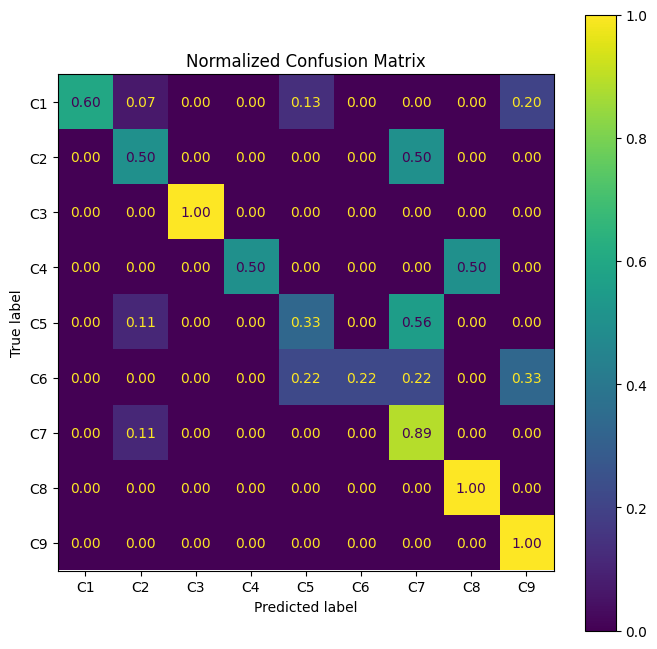


Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.600     0.750        15
           1      0.400     0.500     0.444         4
           2      1.000     1.000     1.000         4
           3      1.000     0.500     0.667         2
           4      0.429     0.333     0.375         9
           5      1.000     0.222     0.364         9
           6      0.471     0.889     0.615         9
           7      0.667     1.000     0.800         2
           8      0.455     1.000     0.625         5

    accuracy                          0.610        59
   macro avg      0.713     0.672     0.627        59
weighted avg      0.734     0.610     0.598        59



In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ----------------------------
# Evaluate on test data
# ----------------------------
# Predict on test set
test_pred = np.argmax(model.predict(test_input), axis=1)
test_true = np.argmax(test_output, axis=1)

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(test_true, test_pred, normalize='true')  # normalized by class
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'C{i+1}' for i in range(N_CLASSES)])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='viridis', values_format=".2f", colorbar=True)
plt.title("Normalized Confusion Matrix")
plt.show()

# ----------------------------
# Classification Report
# ----------------------------
print("\nClassification Report:")
print(classification_report(test_true, test_pred, digits=3))

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


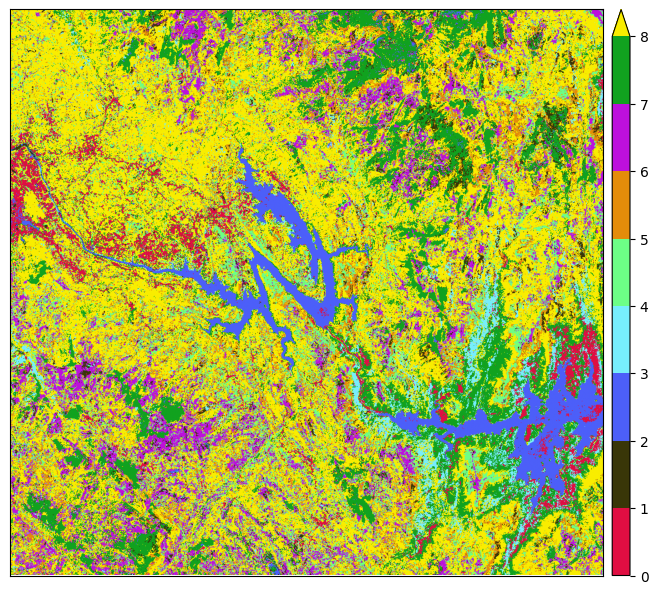

In [130]:
# ----------------------------
# Load raster image and prepare input
# ----------------------------
image = rasterio.open(IMAGE_PATH)
height, width = image.height, image.width
bands = []

for b in range(1, 15):  # 14 bands/features
    bands.append(image.read(b))
image_array = np.stack(bands, axis=0).reshape(14, -1).T  # (height*width, 14)
image_array_scaled = scaler.transform(image_array).reshape(-1, 14, 1)

# ----------------------------
# Predict image
# ----------------------------
prediction = model.predict(image_array_scaled, batch_size=4096)
prediction = np.argmax(prediction, axis=1)  # 0-8
prediction = prediction.reshape(height, width)  # reshape to image

# ----------------------------
# Plot
# ----------------------------
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()


In [115]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL/'
name = 'LC_2024_tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()

In [105]:
# Final training and validation accuracy
final_train_acc = history['accuracy'].iloc[-1]
final_val_acc = history['val_accuracy'].iloc[-1]

print(f"Final Training Accuracy: {final_train_acc:.3f}")
print(f"Final Validation (Test) Accuracy: {final_val_acc:.3f}")


Final Training Accuracy: 0.621
Final Validation (Test) Accuracy: 0.525


In [106]:
test_loss, test_accuracy = model.evaluate(test_input, test_output, verbose=0)
print(f"Test Accuracy (evaluate): {test_accuracy:.3f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy (evaluate): 0.542
Test Loss: 1.2617
